<a href="https://colab.research.google.com/github/satani99/practical_deep_learning_for_coders/blob/main/fast_ai_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *

In [2]:
top_edge = tensor([[1, 1, 1],
                   [0, 0, 0],
                   [-1, -1, -1]]).float()

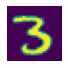

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [4]:
im3_t = tensor(im3)
im3_t[0:3, 0:3] * top_edge 

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [-0., -0., -0.]])

In [5]:
(im3_t[0:3, 0:3] * top_edge).sum()

tensor(0.)

In [6]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [7]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(-762.)

In [8]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(29.)

In [9]:
def apply_kernel(row, col, kernel):
  return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()

apply_kernel(5, 7, top_edge)

tensor(-762.)

In [10]:
[[(i,j) for j in range(1, 5)] for i in range(1, 5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

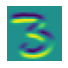

In [11]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

show_image(top_edge3);

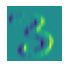

In [12]:
left_edge = tensor([[0, 1, -1],
                    [0, 1, -1],
                    [0, 1, -1]]).float()

left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])

show_image(left_edge3);

In [13]:
diag1_edge = tensor([[0,-1,1],
                     [-1,1,0],
                     [1,0,0]]).float()
diag2_edge = tensor([[1,-1,0],
                     [0,1,-1],
                     [0,0,1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape    

torch.Size([4, 3, 3])

In [14]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [15]:
xb, yb = to_cpu(xb), to_cpu(yb)

In [16]:
edge_kernels.shape, edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [17]:
edge_kernels = edge_kernels.unsqueeze(1)

batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

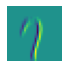

In [18]:
show_image(batch_features[0,0]);

In [19]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [20]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1)
)

In [21]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [22]:
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

In [23]:
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 32),
    conv(32, 2, act=False),
    Flatten(),
)

In [24]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [25]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [26]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [27]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.061138,0.042800,0.984298,00:16
1,0.019553,0.024603,0.991168,00:19


In [28]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [29]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [30]:
m[0].bias.shape

torch.Size([4])

In [32]:
im = image2tensor(Image.open('/content/grizzly.jpeg'))
im.shape

torch.Size([3, 108, 150])

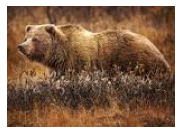

In [33]:
show_image(im);

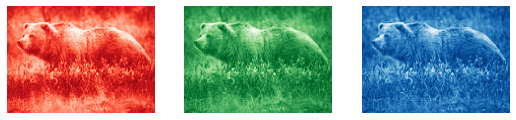

In [34]:
_, axs = subplots(1, 3)
for bear, ax, color in zip(im, axs, ('Reds', 'Greens', 'Blues')):
  show_image(255-bear, ax=ax, cmap=color)

In [35]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [36]:
def get_dls(bs=64):
  return DataBlock(
      blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
      get_items=get_image_files,
      splitter=GrandparentSplitter('training', 'testing'),
      get_y=parent_label,
      batch_tfms=Normalize()
  ).dataloaders(path, bs=bs)

dls = get_dls()

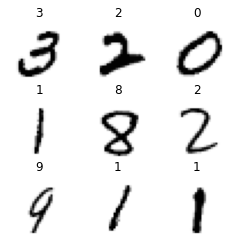

In [37]:
dls.show_batch(max_n=9, figsize=(4, 4))

In [38]:
def simple_cnn():
  return nn.Sequential(
      conv(1, 8, ks=5),
      conv(8, 16),
      conv(16, 32),
      conv(32, 64),
      conv(64, 10, act=False),
      Flatten(),
  )

In [39]:
from fastai.callback.hook import *

In [40]:
def fit(epochs=1):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                  metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit(epochs, 0.06)
  return learn 

learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.305335,2.305351,0.102800,01:36


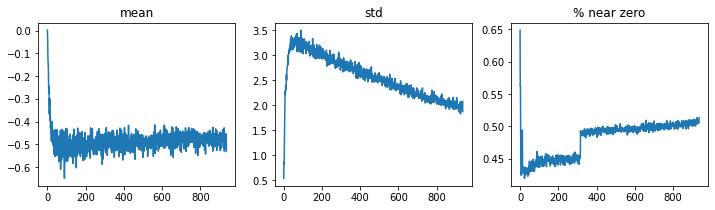

In [41]:
learn.activation_stats.plot_layer_stats(0)

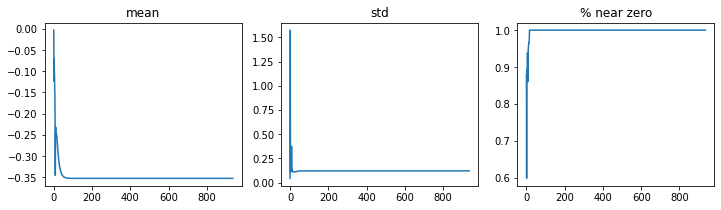

In [42]:
learn.activation_stats.plot_layer_stats(-2)

In [43]:
dls = get_dls(512)
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.448974,0.288073,0.909700,01:24


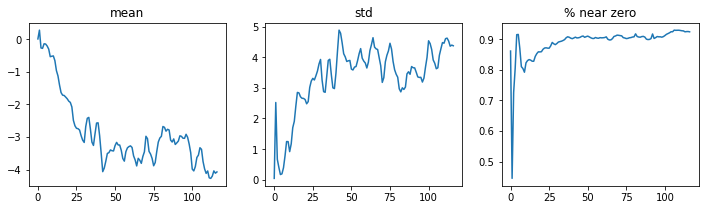

In [44]:
learn.activation_stats.plot_layer_stats(-2)